In [3]:
import numpy
import pandas
import matplotlib.pyplot as plt 

In [4]:
dataset=pandas.read_csv("Datasets/Self_Organizing_Maps/Credit_Card_Applications.csv")
x_names=[data for data in dataset if data!="Class"]
y_names=[data for data in dataset if data=="Class"]
x=dataset[x_names]
y=dataset[y_names].values

In [14]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0, 1))
x=sc.fit_transform(x)
som=MiniSom(x=10, y=10, input_len=15, sigma=1.0, learning_rate=0.3)
som.random_weights_init(x)
som.train_random(data=x, num_iteration=300)

In [13]:
from math import sqrt

from numpy import (array, unravel_index, nditer, linalg, random, subtract, power, exp, pi, zeros, arange, outer, meshgrid, dot)
from collections import defaultdict
from warnings import warn


"""
    Minimalistic implementation of the Self Organizing Maps (SOM).
"""

def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.

    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return sqrt(dot(x, x.T))


class MiniSom(object):
    def __init__(self, x, y, input_len, sigma=1.0, learning_rate=0.5, decay_function=None, random_seed=None):
        """
            Initializes a Self Organizing Maps.
            x,y - dimensions of the SOM
            input_len - number of the elements of the vectors in input
            sigma - spread of the neighborhood function (Gaussian), needs to be adequate to the dimensions of the map.
            (at the iteration t we have sigma(t) = sigma / (1 + t/T) where T is #num_iteration/2)
            learning_rate - initial learning rate
            (at the iteration t we have learning_rate(t) = learning_rate / (1 + t/T) where T is #num_iteration/2)
            decay_function, function that reduces learning_rate and sigma at each iteration
                            default function: lambda x,current_iteration,max_iter: x/(1+current_iteration/max_iter)
            random_seed, random seed to use.
        """
        if sigma >= x/2.0 or sigma >= y/2.0:
            warn('Warning: sigma is too high for the dimension of the map.')
        if random_seed:
            self.random_generator = random.RandomState(random_seed)
        else:
            self.random_generator = random.RandomState(random_seed)
        if decay_function:
            self._decay_function = decay_function
        else:
            self._decay_function = lambda x, t, max_iter: x/(1+t/max_iter)
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.weights = self.random_generator.rand(x,y,input_len)*2-1 # random initialization
        for i in range(x):
            for j in range(y):
                self.weights[i,j] = self.weights[i,j] / fast_norm(self.weights[i,j]) # normalization
        self.activation_map = zeros((x,y))
        self.neigx = arange(x)
        self.neigy = arange(y) # used to evaluate the neighborhood function
        self.neighborhood = self.gaussian

    def _activate(self, x):
        """ Updates matrix activation_map, in this matrix the element i,j is the response of the neuron i,j to x """
        s = subtract(x, self.weights) # x - w
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.activation_map[it.multi_index] = fast_norm(s[it.multi_index])  # || x - w ||
            it.iternext()

    def activate(self, x):
        """ Returns the activation map to x """
        self._activate(x)
        return self.activation_map

    def gaussian(self, c, sigma):
        """ Returns a Gaussian centered in c """
        d = 2*pi*sigma*sigma
        ax = exp(-power(self.neigx-c[0], 2)/d)
        ay = exp(-power(self.neigy-c[1], 2)/d)
        return outer(ax, ay)  # the external product gives a matrix

    def diff_gaussian(self, c, sigma):
        """ Mexican hat centered in c (unused) """
        xx, yy = meshgrid(self.neigx, self.neigy)
        p = power(xx-c[0], 2) + power(yy-c[1], 2)
        d = 2*pi*sigma*sigma
        return exp(-p/d)*(1-2/d*p)

    def winner(self, x):
        """ Computes the coordinates of the winning neuron for the sample x """
        self._activate(x)
        return unravel_index(self.activation_map.argmin(), self.activation_map.shape)

    def update(self, x, win, t):
        """
            Updates the weights of the neurons.
            x - current pattern to learn
            win - position of the winning neuron for x (array or tuple).
            t - iteration index
        """
        eta = self._decay_function(self.learning_rate, t, self.T)
        sig = self._decay_function(self.sigma, t, self.T) # sigma and learning rate decrease with the same rule
        g = self.neighborhood(win, sig)*eta # improves the performances
        it = nditer(g, flags=['multi_index'])
        while not it.finished:
            # eta * neighborhood_function * (x-w)
            self.weights[it.multi_index] += g[it.multi_index]*(x-self.weights[it.multi_index])
            # normalization
            self.weights[it.multi_index] = self.weights[it.multi_index] / fast_norm(self.weights[it.multi_index])
            it.iternext()

    def quantization(self, data):
        """ Assigns a code book (weights vector of the winning neuron) to each sample in data. """
        q = zeros(data.shape)
        for i, x in enumerate(data):
            q[i] = self.weights[self.winner(x)]
        return q

    def random_weights_init(self, data):
        """ Initializes the weights of the SOM picking random samples from data """
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.weights[it.multi_index] = data[self.random_generator.randint(len(data))]
            self.weights[it.multi_index] = self.weights[it.multi_index]/fast_norm(self.weights[it.multi_index])
            it.iternext()

    def train_random(self, data, num_iteration):
        """ Trains the SOM picking samples at random from data """
        self._init_T(num_iteration)
        for iteration in range(num_iteration):
            rand_i = self.random_generator.randint(len(data)) # pick a random sample
            self.update(data[rand_i], self.winner(data[rand_i]), iteration)

    def train_batch(self, data, num_iteration):
        """ Trains using all the vectors in data sequentially """
        self._init_T(len(data)*num_iteration)
        iteration = 0
        while iteration < num_iteration:
            idx = iteration % (len(data)-1)
            self.update(data[idx], self.winner(data[idx]), iteration)
            iteration += 1

    def _init_T(self, num_iteration):
        """ Initializes the parameter T needed to adjust the learning rate """
        self.T = num_iteration/2  # keeps the learning rate nearly constant for the last half of the iterations

    def distance_map(self):
        """ Returns the distance map of the weights.
            Each cell is the normalised sum of the distances between a neuron and its neighbours.
        """
        um = zeros((self.weights.shape[0], self.weights.shape[1]))
        it = nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1, it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1, it.multi_index[1]+2):
                    if ii >= 0 and ii < self.weights.shape[0] and jj >= 0 and jj < self.weights.shape[1]:
                        um[it.multi_index] += fast_norm(self.weights[ii, jj, :]-self.weights[it.multi_index])
            it.iternext()
        um = um/um.max()
        return um

    def activation_response(self, data):
        """
            Returns a matrix where the element i,j is the number of times
            that the neuron i,j have been winner.
        """
        a = zeros((self.weights.shape[0], self.weights.shape[1]))
        for x in data:
            a[self.winner(x)] += 1
        return a

    def quantization_error(self, data):
        """
            Returns the quantization error computed as the average distance between
            each input sample and its best matching unit.
        """
        error = 0
        for x in data:
            error += fast_norm(x-self.weights[self.winner(x)])
        return error/len(data)

    def win_map(self, data):
        """
            Returns a dictionary wm where wm[(i,j)] is a list with all the patterns
            that have been mapped in the position i,j.
        """
        winmap = defaultdict(list)
        for x in data:
            winmap[self.winner(x)].append(x)
        return winmap

In [15]:
from pylab import bone, pcolor, colorbar, plot, show

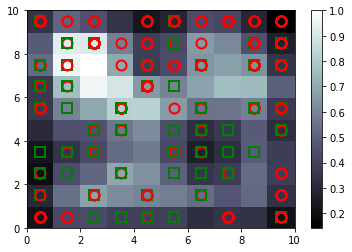

In [16]:
bone()
pcolor(som.distance_map().T)
colorbar()
markers=['o','s']
colors=['r', 'g']
for i, val in enumerate(x):
    w=som.winner(val)
    plot(w[0]+0.5, w[1]+0.5, markers[y[i][0]], markeredgecolor=colors[y[i][0]], markerfacecolor='None', markersize=10, markeredgewidth=2)
show()

In [17]:
mappings=som.win_map(x)

In [18]:
frauds=numpy.concatenate((mappings[(1,7)], mappings[(1, 8)], mappings[(2, 8)]))

In [20]:
frauds=sc.inverse_transform(frauds)

In [26]:
customers_tname=[data for data in dataset if data!="CustomerID"]
customers=dataset[customers_tname]

In [34]:
is_Fraud=numpy.zeros(len(dataset))
for i in range(len(dataset)):
    if dataset.iloc[i,0] in frauds:
        is_Fraud[i]=1

In [38]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
customers=sc.fit_transform(customers)

In [39]:
from keras.layers import Dense
from keras.models import Sequential

In [40]:
classifier=Sequential()
classifier.add(Dense(units=2, kernel_initializer="uniform", activation="relu", input_dim=15))
classifier.add(Dense(units=1, kernel_initializer="uniform", activation="sigmoid"))
classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [43]:
classifier.fit(customers, is_Fraud, batch_size=1, epochs=10, shuffle=True, verbose=1)

Epoch 1/10
690/690 [==============================] - 1s 2ms/step - loss: 0.0760 - accuracy: 0.9551
Epoch 2/10
690/690 [==============================] - 1s 2ms/step - loss: 0.0726 - accuracy: 0.9551
Epoch 3/10
690/690 [==============================] - 1s 2ms/step - loss: 0.0701 - accuracy: 0.9551
Epoch 4/10
690/690 [==============================] - 1s 2ms/step - loss: 0.0660 - accuracy: 0.9551
Epoch 5/10
690/690 [==============================] - 1s 2ms/step - loss: 0.0636 - accuracy: 0.9551
Epoch 6/10
690/690 [==============================] - 1s 2ms/step - loss: 0.0611 - accuracy: 0.9551
Epoch 7/10
690/690 [==============================] - 1s 2ms/step - loss: 0.0585 - accuracy: 0.9551
Epoch 8/10
690/690 [==============================] - 1s 2ms/step - loss: 0.0557 - accuracy: 0.9551
Epoch 9/10
690/690 [==============================] - 1s 2ms/step - loss: 0.0526 - accuracy: 0.9551
Epoch 10/10
690/690 [==============================] - 1s 2ms/step - loss: 0.0506 - accuracy: 0.9551

In [44]:
y_pred=classifier.predict(customers)

In [47]:
y_pred=numpy.concatenate((dataset.iloc[:,0:1], y_pred), axis=1)

In [50]:
y_pred_sort=y_pred[y_pred[:,1].argsort()]

In [56]:
y_pred_sort[650:,:]

array([[1.55795830e+07, 2.06544429e-01],
       [1.55933450e+07, 2.41743207e-01],
       [1.57862370e+07, 2.45751560e-01],
       [1.57176290e+07, 3.44164610e-01],
       [1.57345780e+07, 3.47700268e-01],
       [1.56389830e+07, 3.57147992e-01],
       [1.58028690e+07, 3.64057600e-01],
       [1.56355980e+07, 3.67541105e-01],
       [1.58005540e+07, 3.79796982e-01],
       [1.56650140e+07, 4.18775767e-01],
       [1.55904340e+07, 4.31918740e-01],
       [1.56232100e+07, 4.35388625e-01],
       [1.56417330e+07, 4.42471683e-01],
       [1.57661830e+07, 4.46247578e-01],
       [1.57673580e+07, 4.68976080e-01],
       [1.56601440e+07, 4.72817659e-01],
       [1.57723290e+07, 4.73076165e-01],
       [1.56961200e+07, 4.80724752e-01],
       [1.56628540e+07, 4.80724752e-01],
       [1.57453750e+07, 4.80724752e-01],
       [1.55681620e+07, 4.80724752e-01],
       [1.56179910e+07, 4.80724752e-01],
       [1.56621520e+07, 4.80724752e-01],
       [1.56387510e+07, 4.80724752e-01],
       [1.557050